# Cross-validation
This notebook shows how to use cross-validation techniques from [Scikit-learn](https://scikit-learn.org/stable/) to tune parameters.

Note that the `pandas` package is required to run this notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets

import pysensors as ps

## Setup

First we'll load some training data. In this case, images of handwritten digits.

In [2]:
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target

n_samples, n_features = X.shape
print(n_samples, n_features)

1083 64


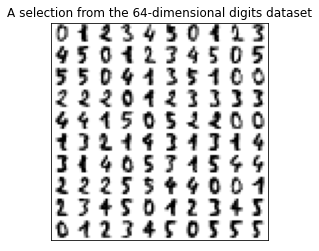

In [3]:
# Plot some digits
n_img_per_row = 10
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')
plt.show()

## Grid search
Here we specify a set of parameter values we'd like to test. The `GridSearchCV` object will try out every possible combination and tell us which gave the best performance.

In [4]:
from sklearn.model_selection import GridSearchCV

model = ps.reconstruction.SSPOR()

param_grid = {
    "basis": [ps.basis.Identity(), ps.basis.SVD(), ps.basis.RandomProjection()],
    "basis__n_basis_modes": [20, 30, 40, 50],
    "n_sensors": [10, 20, 30, 40]
}

search = GridSearchCV(model, param_grid)
search.fit(X, quiet=True)
print("Best parameters:")
for k, v in search.best_params_.items():
    print(f"{k}:  {v}")

Best parameters:
basis:  SVD(n_basis_modes=40)
basis__n_basis_modes:  40
n_sensors:  40


We can also visualize the performance of each candidate model to get a better idea how the different parameters interact. The pandas and seaborn packages help simplify the task.

In [5]:
def rename_bases(s):
        if 'Identity' in str(s):
            return 'Identity'
        elif 'SVD' in str(s):
            return 'SVD'
        elif 'RandomProjection' in str(s):
            return 'RandomProjection'
        else:
            return "N/A"

def create_dataframe(results):
    results_df = pd.DataFrame.from_dict(results)
    
    # Rename the basis objects for plotting purposes
    results_df['basis'] = results_df['param_basis'].apply(rename_bases)

    # We were working with the negative mean-square error before
    results_df['neg_mean_test_score'] = -results_df['mean_test_score']
    
    return results_df

def generate_summary_plots(results):
    results = create_dataframe(results)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    sns.barplot(data=results, x='param_basis__n_basis_modes', y='neg_mean_test_score', hue='basis', ax=axs[0])
    sns.barplot(data=results, x='param_n_sensors', y='neg_mean_test_score', hue='basis', ax=axs[1])
    axs[0].set(xlabel='n_basis_modes', ylabel='Mean square error')
    axs[1].set(xlabel='n_sensors', ylabel='Mean square error')
    fig.show()

/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/venv/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


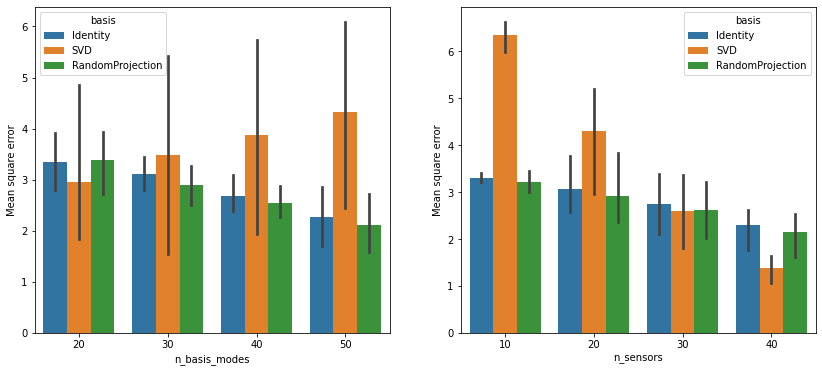

In [6]:
generate_summary_plots(search.cv_results_)

The error bars in the left subplot come from different choices of `n_sensors`. Those on the right come from different values of `n_basis_modes`. Note that the performance of the `SVD` basis is more sensitive to low sensor counts than the other two bases, but it does very well once enough sensors are in place.

We can also look more closely at how the different bases are affected by differing numbers of sensors.

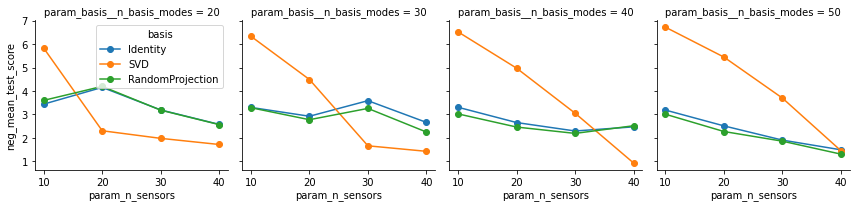

In [7]:
# Rename basis objects
results = create_dataframe(search.cv_results_)

# Initialize a grid with a plot for each number of basis modes
grid = sns.FacetGrid(results, col="param_basis__n_basis_modes", hue="basis", legend_out=False)

# Create a plot for each instance
grid.map(plt.plot, "param_n_sensors", "neg_mean_test_score", marker="o").add_legend()
grid.fig.tight_layout()
plt.show()

* **SVD** - Performance generally increases as the number of sensors are increased. For low sensor counts, this basis is beat out by the other two.
* **Identity** - Works best when lots of modes are retained, even for low values of `n_sensors`.
* **RandomProjection** - Similar performance to the `Identity` basis on this example.

## Randomized search

Now suppose we have a fixed sensor budget. We'd like to determine the best basis in which to represent the data to make the most of these sensors. Suppose further that we want to test out a larger number of candidates for `n_basis_modes`. We can obtain a good approximation to the optimal parameter configuration for a fraction of the cost using Scikit-learn's [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) object.

In [8]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

model = ps.reconstruction.SSPOR(n_sensors=30)

param_distributions = {
    "basis": [ps.basis.Identity(), ps.basis.SVD(), ps.basis.RandomProjection()],
    "basis__n_basis_modes": randint(10, 50)
}

search = RandomizedSearchCV(model, param_distributions, n_iter=30)
search.fit(X, quiet=True)
for k, v in search.best_params_.items():
    print(f"{k}:  {v}")

basis:  SVD(n_basis_modes=27)
basis__n_basis_modes:  27


/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/venv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


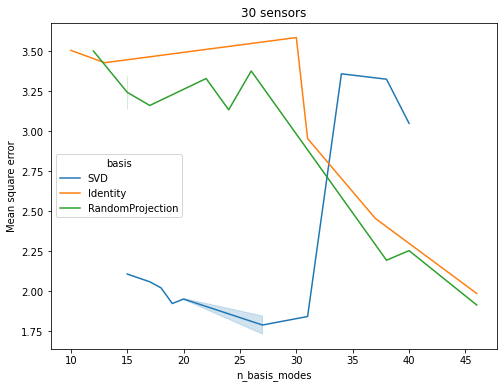

In [9]:
results = pd.DataFrame.from_dict(search.cv_results_)

# Rename the basis objects for plotting purposes
def rename_bases(s):
    if 'Identity' in str(s):
        return 'Identity'
    elif 'SVD' in str(s):
        return 'SVD'
    elif 'RandomProjection' in str(s):
        return 'RandomProjection'
    else:
        return "N/A"

results['basis'] = results['param_basis'].apply(rename_bases)

# We were working with the negative mean-square error before
results['neg_mean_test_score'] = -results['mean_test_score']

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.lineplot(
    markers=True,
    data=results,
    x='param_basis__n_basis_modes',
    y='neg_mean_test_score',
    hue='basis',
    ax=ax
)
ax.set(xlabel='n_basis_modes', ylabel='Mean square error', title='30 sensors')
fig.show()

The `Identity` and `RandomProjection` bases appear to benefit from increasing the number of basis modes. Once the number of basis modes exceeds the number of sensors, the performance of the `SVD` basis drops off. Its accuracy curve shows that it is adept at compressing information as it attains good scores for low numbers of basis modes.

Note that the basis is recomputed for each value of `n_basis_modes`, which may create misleading results for the `RandomProjection` basis. Normally to increase the size of the basis one would simply add a new randomly projection vector to the existing basis, in which case we would expect to see something much closer to a monotonoic decrease in mean-square error in as `n_basis_modes` is increased.

See [this notebook](https://github.com/dynamicslab/pysensors/blob/master/examples/basis_comparison.ipynb) for a more in-depth comparison of the bases.